In [2]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [4]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,WordCount,Normalized Text,Tokenized Text,Text_No_Stop_Words,Lemmatized Text
0,0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,48,i have bought several of the vitality canned d...,"['i', 'have', 'bought', 'several', 'of', 'the'...","['bought', 'several', 'vitality', 'canned', 'd...","[bought, several, vitality, canned, dog, food,..."
1,1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN,31,product arrived labelled as lumbo halted peanu...,"['product', 'arrived', 'labelled', 'as', 'lumb...","['product', 'arrived', 'labelled', 'lumbo', 'h...","[product, arrived, labelled, lumbo, halted, pe..."
2,2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,94,this is a connection that has been around a fe...,"['this', 'is', 'a', 'connection', 'that', 'has...","['connection', 'around', 'centuries', 'light',...","[connection, around, century, light, pillow, c..."
3,3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0,41,if you are looking for the secret ingredient i...,"['if', 'you', 'are', 'looking', 'for', 'the', ...","['looking', 'secret', 'ingredient', 'robitussi...","[looking, secret, ingredient, robitussin, beli..."
4,4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN,27,great staff at a great price there was a wide...,"['great', 'staff', 'at', 'a', 'great', 'price'...","['great', 'staff', 'great', 'price', 'wide', '...","[great, staff, great, price, wide, assortment,..."


# Classificazione

In [6]:
classification_df = df[['Score', 'Lemmatized Text']]

Text(0, 0.5, 'Number of reviews')

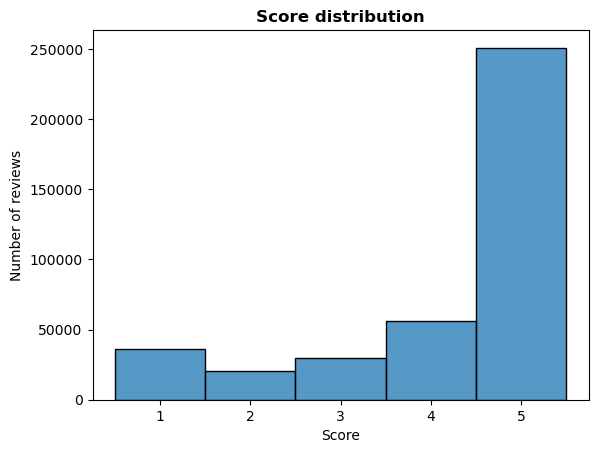

In [7]:
sns.histplot(classification_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [8]:
print(classification_df['Score'].value_counts()/len(classification_df['Score']));

5    0.637067
4    0.142392
1    0.092164
3    0.075570
2    0.052807
Name: Score, dtype: float64


Le classi sono fortemente sbilanciate, con quasi il 78% delle review appartenenti alla classe 4 e 5. E' necessaria una procedura di resampling, in modo tale che i classificatori non diano stime distorte (classificando tutte le review come appartenenti alla classe 5 si otterrebbe comunque il 63% di accuratezza).

In [9]:
# Come sample size prendo il totale delle review appartenenti alla classe meno numerosa

sample_size = classification_df.groupby('Score').count().min()[0]

In [10]:
df_downsampled = classification_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Score,Lemmatized Text
292789,1,"[ranch, favorite, dressing, know, good, ranch,..."
356988,1,"[threw, country, origin, listed, said, package..."
247937,1,"[hoping, original, version, stride, sweet, pep..."
51556,1,"[cipriani, telling, ny, great, drink, reasonab..."
337387,1,"[soup, great, denied, small, return, dont, end..."
...,...,...
140522,5,"[made, allrye, bread, using, bob, organic, dar..."
188621,5,"[extremely, pleased, discover, product, weight..."
138011,5,"[say, dog, treat, either, dog, like, dont, min..."
92501,5,"[bought, wife, note, supermarket, checkout, st..."


Text(0, 0.5, 'Number of reviews')

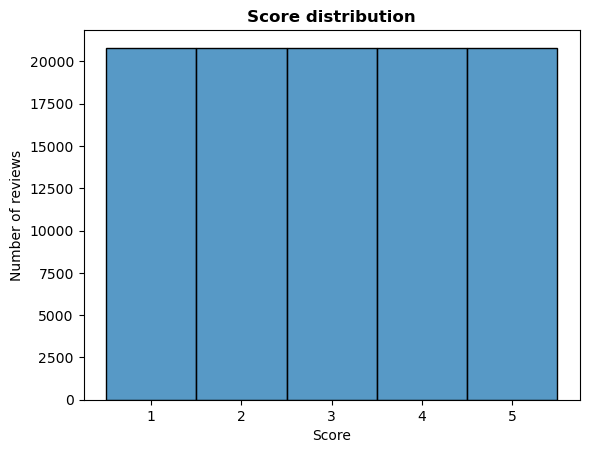

In [11]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [12]:
# Separo train e test

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['Lemmatized Text'], 
                                                    df_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=df_downsampled['Score'])

# Multi-label classification

## BOW

In [13]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(X_train.astype(str)) 
X_train_BOW = cv_model.transform(X_train.astype(str))

In [14]:
X_train_BOW.shape

(72807, 79788)

Devo necessariamente ridurre la dimensionalità della matrice:

In [15]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(X_train_BOW)
X_train_BOW = tSVD_BOW.transform(X_train_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.8013172867328977


In [16]:
# Applico la stessa trasformazione al Test

X_test_BOW = cv_model.transform(X_test.astype(str))
X_test_BOW = SVD_BOW.transform(X_test_BOW)

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- ...

In [17]:
# Regressione logistica

lr_BOW = LogisticRegression(random_state=1)
model_lr_BOW = lr_BOW.fit(X_train_BOW, y_train)
predictions_lr_BOW = model_lr_BOW.predict(X_test_BOW)

In [18]:
# Random Forest

rf_BOW = RandomForestClassifier(n_jobs = -1)
model_rf_BOW = rf_BOW.fit(X_train_BOW, y_train)
predictions_rf_BOW = model_rf_BOW.predict(X_test_BOW)

Analizzo i risultati:

In [19]:
def evaluation(prediction, ground_truth):
  print(confusion_matrix(ground_truth, prediction))
  print(classification_report(ground_truth, prediction))

In [20]:
# Regressione Logistica

evaluation(predictions_lr_BOW, y_test)

[[4005 1186  443  267  340]
 [1751 2187 1271  561  470]
 [ 798 1310 2170 1358  604]
 [ 321  488 1096 2521 1815]
 [ 328  260  289 1060 4304]]
              precision    recall  f1-score   support

           1       0.56      0.64      0.60      6241
           2       0.40      0.35      0.37      6240
           3       0.41      0.35      0.38      6240
           4       0.44      0.40      0.42      6241
           5       0.57      0.69      0.62      6241

    accuracy                           0.49     31203
   macro avg       0.48      0.49      0.48     31203
weighted avg       0.48      0.49      0.48     31203



In [21]:
# Random Forest

evaluation(predictions_rf_BOW, y_test)

[[3025 1286  817  547  566]
 [1854 1597 1289  855  645]
 [1180 1372 1736 1172  780]
 [ 801 1015 1382 1633 1410]
 [ 812  752  786 1198 2693]]
              precision    recall  f1-score   support

           1       0.39      0.48      0.43      6241
           2       0.27      0.26      0.26      6240
           3       0.29      0.28      0.28      6240
           4       0.30      0.26      0.28      6241
           5       0.44      0.43      0.44      6241

    accuracy                           0.34     31203
   macro avg       0.34      0.34      0.34     31203
weighted avg       0.34      0.34      0.34     31203



## TF-IDF

In [22]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(X_train.astype(str))
X_train_TFIDF = tv.transform(X_train.astype(str))

In [23]:
X_train_TFIDF.shape

(72807, 79788)

In [24]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(X_train_TFIDF)
X_train_TFIDF = tSVD_TFIDF.transform(X_train_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5681461296752753


In [25]:
# Applico la stessa trasformazione al Test

X_test_TFIDF = tv_model.transform(X_test.astype(str))
X_test_TFIDF = SVD_TFIDF.transform(X_test_TFIDF)

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- ...

In [26]:
# Regressione logistica

lr_TFIDF = LogisticRegression(random_state=1)
model_lr_TFIDF = lr_TFIDF.fit(X_train_TFIDF, y_train)
predictions_lr_TFIDF = model_lr_TFIDF.predict(X_test_TFIDF)

In [27]:
# Random Forest

rf_TFIDF = RandomForestClassifier(n_jobs = -1)
model_rf_TFIDF = rf_TFIDF.fit(X_train_TFIDF, y_train)
predictions_rf_TFIDF = model_rf_TFIDF.predict(X_test_TFIDF)

Analizzo i risultati:

In [28]:
# Regressione Logistica

evaluation(predictions_lr_TFIDF, y_test)

[[4000 1269  479  216  277]
 [1626 2289 1363  524  438]
 [ 778 1294 2360 1290  518]
 [ 335  457 1150 2642 1657]
 [ 316  246  324 1196 4159]]
              precision    recall  f1-score   support

           1       0.57      0.64      0.60      6241
           2       0.41      0.37      0.39      6240
           3       0.42      0.38      0.40      6240
           4       0.45      0.42      0.44      6241
           5       0.59      0.67      0.63      6241

    accuracy                           0.50     31203
   macro avg       0.49      0.50      0.49     31203
weighted avg       0.49      0.50      0.49     31203



In [29]:
# Random Forest
evaluation(predictions_rf_TFIDF, y_test)

[[3297 1267  714  461  502]
 [1877 1641 1271  775  676]
 [1254 1304 1562 1294  826]
 [ 756  908 1210 1746 1621]
 [ 653  657  668 1281 2982]]
              precision    recall  f1-score   support

           1       0.42      0.53      0.47      6241
           2       0.28      0.26      0.27      6240
           3       0.29      0.25      0.27      6240
           4       0.31      0.28      0.30      6241
           5       0.45      0.48      0.46      6241

    accuracy                           0.36     31203
   macro avg       0.35      0.36      0.35     31203
weighted avg       0.35      0.36      0.35     31203



## W2V Representation

In [30]:
# Creo il modello W2V sul training
w2v_model = gensim.models.Word2Vec(X_train, vector_size=300, window=8, min_count=2)

In [31]:
# Ho a disposizione il modello W2V, che ha convertito ogni parola presente nel training (nello specifico, deve essere presente almeno
# due volte --> min_count=2) in un vettore a 100 componenti. Per generare un vettore rappresentativo di ciascuna review andrò a creare un
# vettore costituito dalla media (componente per componente) dei vettori delle parole appartenenti alla review

# https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

words = set(w2v_model.wv.index_to_key) # Lista di parole presenti nel modello W2V

# Creo due liste, una per il training e una per il test. Ciascuna lista contiene come elementi delle altre liste. Ciascun elemento (ciascuna
# lista) contiene i vettori relativi alle parole di una specifica review (una lista per review contenente i vettori delle singole parole)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

In [32]:
# Per spiegare meglio quanto fatto sopra uso questo esempio:
# La prima review del training è la seguente
X_train.head(1)

214310    [love, coffee, favored, morning, look, forward...
Name: Lemmatized Text, dtype: object

In [33]:
# Le prime due parole sono 'love' e 'walker'. Stampo i vettori di queste due parole
w2v_model.wv.get_vector('love')

array([-2.74816714e-02,  1.61570895e+00, -1.22481978e+00, -3.36299717e-01,
       -1.40039194e+00, -2.79828697e-01,  2.42731169e-01,  1.25611210e+00,
       -2.77778618e-02,  2.33590305e-01,  6.82685316e-01,  2.16516995e+00,
        3.34572941e-01, -6.51716888e-01,  1.44943535e+00,  2.74506241e-01,
        9.71979052e-02, -3.68879229e-01,  6.12010002e-01, -1.10969102e+00,
        9.22294199e-01,  6.04381025e-01, -1.44163415e-01,  2.88761288e-01,
       -8.69179606e-01,  9.77400094e-02, -6.39101505e-01, -5.51978886e-01,
       -2.53474236e+00, -1.33472905e-01, -5.78156888e-01, -6.40612781e-01,
        2.33872151e+00, -2.02732265e-01,  4.84106928e-01,  1.60157561e+00,
        1.05928183e+00,  8.18020523e-01,  4.97886240e-02,  1.67076850e+00,
       -1.04959059e+00,  1.13562024e+00,  7.04208687e-02, -2.76327312e-01,
        1.11288941e+00,  1.41444743e-01, -4.09622759e-01,  1.96663439e+00,
        6.71902597e-01, -1.18128955e+00,  2.13362649e-01, -1.54980123e-01,
       -1.02936792e+00, -

In [34]:
w2v_model.wv.get_vector('walker')

array([ 0.06383006,  0.17453107, -0.01681529,  0.06515118, -0.18744314,
       -0.07721217,  0.03718842,  0.12701407, -0.0190195 ,  0.00492431,
        0.0608492 , -0.00044137,  0.06174381, -0.03729996,  0.09461696,
       -0.01166137,  0.06302179,  0.00319695, -0.17184933,  0.07541018,
       -0.1921557 ,  0.06857599,  0.14275312,  0.07788329,  0.07081403,
        0.03749082, -0.15899615, -0.03299461, -0.1843697 , -0.04438698,
        0.03527053, -0.1012674 ,  0.13469447,  0.06219578,  0.04859598,
        0.12651193, -0.03625322,  0.01181418,  0.05929058,  0.09823082,
        0.03822974,  0.14939597, -0.05685461, -0.05640768,  0.13160709,
        0.11646594,  0.10863084,  0.15357348, -0.04321549,  0.09532842,
       -0.04024762, -0.01482457, -0.13068755, -0.14872976, -0.06881903,
        0.24277417, -0.00906169, -0.00560756, -0.01805649,  0.08420406,
       -0.02932542,  0.10513626,  0.06016027,  0.12234621,  0.10536391,
        0.08382092, -0.0331003 ,  0.1146715 ,  0.07509843, -0.14

In [35]:
# Per vedere che sono identici, stampo i primi due elementi della prima lista in X_train_vec. Questi due elementi corrispondono ai vettori
# delle prime due parole della review selezionata, ossia 'love' e 'walker'
X_train_vect[0][0]

array([-2.74816714e-02,  1.61570895e+00, -1.22481978e+00, -3.36299717e-01,
       -1.40039194e+00, -2.79828697e-01,  2.42731169e-01,  1.25611210e+00,
       -2.77778618e-02,  2.33590305e-01,  6.82685316e-01,  2.16516995e+00,
        3.34572941e-01, -6.51716888e-01,  1.44943535e+00,  2.74506241e-01,
        9.71979052e-02, -3.68879229e-01,  6.12010002e-01, -1.10969102e+00,
        9.22294199e-01,  6.04381025e-01, -1.44163415e-01,  2.88761288e-01,
       -8.69179606e-01,  9.77400094e-02, -6.39101505e-01, -5.51978886e-01,
       -2.53474236e+00, -1.33472905e-01, -5.78156888e-01, -6.40612781e-01,
        2.33872151e+00, -2.02732265e-01,  4.84106928e-01,  1.60157561e+00,
        1.05928183e+00,  8.18020523e-01,  4.97886240e-02,  1.67076850e+00,
       -1.04959059e+00,  1.13562024e+00,  7.04208687e-02, -2.76327312e-01,
        1.11288941e+00,  1.41444743e-01, -4.09622759e-01,  1.96663439e+00,
        6.71902597e-01, -1.18128955e+00,  2.13362649e-01, -1.54980123e-01,
       -1.02936792e+00, -

In [36]:
X_train_vect[0][1]

array([ 1.77030981e+00, -3.29851151e+00, -9.12229002e-01, -8.32543671e-01,
        1.27426350e+00,  4.12452370e-01,  7.17946351e-01, -2.11828485e-01,
       -1.10428250e+00, -2.76214391e-01, -5.22241592e-01, -1.22943985e+00,
       -8.02999198e-01,  1.12897146e+00, -2.83139408e-01,  8.94371450e-01,
        7.57966995e-01,  1.33897209e+00, -6.18242741e-01,  1.05193853e+00,
        3.16157490e-01, -2.43075204e+00, -1.82777792e-01, -1.71015215e+00,
       -2.23801937e-02, -1.17240107e+00, -2.30465427e-01,  1.77812338e+00,
        1.68653452e+00, -1.85002357e-01,  5.24808824e-01,  1.10883296e+00,
       -2.02414370e+00,  1.02823174e+00,  1.12032332e-01, -5.57990849e-01,
        1.35909796e+00,  1.25764620e+00,  1.81360710e+00, -3.39099240e+00,
       -2.17518613e-01, -1.43776014e-01,  1.91009665e+00,  1.43902349e+00,
        8.99285302e-02,  3.88001621e-01, -2.60997236e-01,  1.18563676e+00,
        3.73411357e-01, -2.90046841e-01, -1.49804020e+00, -4.80362594e-01,
        5.38012743e-01, -

Andremo a fare un loop su queste liste. Ogni frase avrà un diverso numero di parole e di conseguenza un numero differente di array da mediare

In [37]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

In [38]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

33 300
65 300
156 300
61 300
47 300
61 300
71 300
31 300
14 300
23 300
33 300
14 300
136 300
121 300
13 300
13 300
76 300
71 300
164 300
150 300
13 300
30 300
46 300
22 300
68 300
24 300
36 300
62 300
47 300
82 300
41 300
10 300
14 300
55 300
50 300
43 300
52 300
38 300
33 300
12 300
23 300
149 300
41 300
17 300
303 300
39 300
31 300
31 300
38 300
45 300
9 300
15 300
26 300
43 300
63 300
45 300
35 300
27 300
67 300
11 300
14 300
63 300
20 300
8 300
38 300
91 300
103 300
225 300
101 300
28 300
31 300
49 300
33 300
165 300
10 300
23 300
22 300
93 300
19 300
9 300
48 300
23 300
32 300
18 300
115 300
17 300
13 300
49 300
99 300
23 300
147 300
36 300
23 300
11 300
52 300
60 300
38 300
31 300
45 300
31 300
16 300
49 300
33 300
60 300
9 300
24 300
38 300
11 300
87 300
12 300
39 300
83 300
19 300
20 300
44 300
11 300
38 300
72 300
10 300
13 300
15 300
18 300
14 300
39 300
66 300
11 300
77 300
17 300
46 300
16 300
12 300
29 300
22 300
15 300
13 300
37 300
59 300
15 300
59 300
30 300
32 300
15 3

Come si vede dal for eseguito qui sopra, ogni frase, indipendentemente dal numero di parole che la compongono, corrisponde a un vettore con 300 componenti, creato nello specifico mediando i vettori delle singole parole componente per componente.

X_train_vect_avg e X_test_vect_avg sono i vettori di feature da utilizzare, rispettivamente, per il training del modello e per le previsioni sul test set:

In [39]:
# Regressione logistica

lr_W2V = LogisticRegression(random_state=1)
model_lr_W2V = lr_W2V.fit(X_train_vect_avg, y_train)
predictions_lr_W2V = model_lr_W2V.predict(X_test_vect_avg)

In [40]:
# Random Forest

rf_W2V = RandomForestClassifier(n_jobs = -1)
model_rf_W2V = rf_W2V.fit(X_train_vect_avg, y_train)
predictions_rf_W2V = model_rf_W2V.predict(X_test_vect_avg)

Analisi risultati:

In [41]:
evaluation(predictions_lr_W2V, y_test)

[[3967 1253  471  230  320]
 [1715 2193 1328  576  428]
 [ 857 1305 2193 1331  554]
 [ 380  498 1250 2492 1621]
 [ 398  281  375 1221 3966]]
              precision    recall  f1-score   support

           1       0.54      0.64      0.59      6241
           2       0.40      0.35      0.37      6240
           3       0.39      0.35      0.37      6240
           4       0.43      0.40      0.41      6241
           5       0.58      0.64      0.60      6241

    accuracy                           0.47     31203
   macro avg       0.47      0.47      0.47     31203
weighted avg       0.47      0.47      0.47     31203



In [42]:
evaluation(predictions_rf_W2V, y_test)

[[3823 1302  531  248  337]
 [1765 2034 1311  632  498]
 [1047 1425 1861 1250  657]
 [ 466  710 1238 2045 1782]
 [ 440  391  469 1190 3751]]
              precision    recall  f1-score   support

           1       0.51      0.61      0.55      6241
           2       0.35      0.33      0.34      6240
           3       0.34      0.30      0.32      6240
           4       0.38      0.33      0.35      6241
           5       0.53      0.60      0.57      6241

    accuracy                           0.43     31203
   macro avg       0.42      0.43      0.43     31203
weighted avg       0.42      0.43      0.43     31203



# Classificazione binaria

In [43]:
# Tengo solo gli score diversi da 3
df_binary = classification_df[classification_df['Score']!=3]

In [44]:
# Creo variabile binaria
df_binary.loc[df_binary.Score < 3, "Score"] = 0
df_binary.loc[df_binary.Score > 3, "Score"] = 1
df_binary.head()

,Score,Lemmatized Text
0,1,"[bought, several, vitality, canned, dog, food,..."
1,0,"[product, arrived, labelled, lumbo, halted, pe..."
2,1,"[connection, around, century, light, pillow, c..."
3,0,"[looking, secret, ingredient, robitussin, beli..."
4,1,"[great, staff, great, price, wide, assortment,..."


Text(0, 0.5, 'Number of reviews')

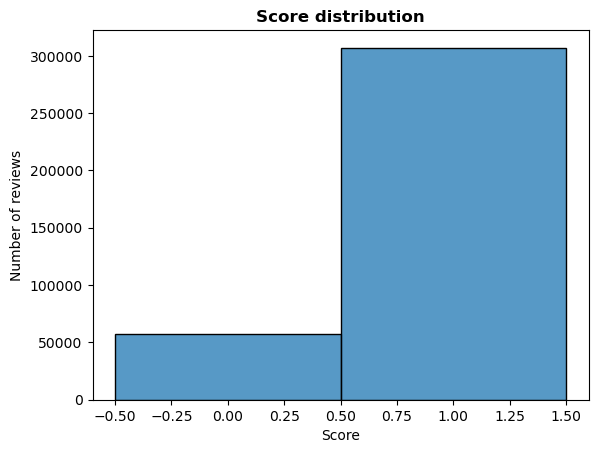

In [45]:
sns.histplot(df_binary['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [46]:
sample_size_binary = df_binary.groupby('Score').count().min()[0]
sample_size_binary

57108

In [47]:
binary_downsampled = df_binary.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size_binary))
binary_downsampled

,Score,Lemmatized Text
167587,0,"[previous, reviewed, mentioned, chocolate, chi..."
300797,0,"[showed, minus, expected, pictured, cocoa, mat..."
2675,0,"[saw, mint, ice, tea, powder, webster, thought..."
78193,0,"[sprayed, deer, around, bird, tender, within, ..."
102327,0,"[heard, walked, farm, product, hadnt, opportun..."
...,...,...
351880,1,"[best, tune, ever, fantastic, flavour, texture..."
47745,1,"[noble, true, italian, past, noble, best, used..."
100514,1,"[tidings, colon, orange, peace, tea, favorite,..."
345565,1,"[look, found, new, langenscheidt, frenchenglis..."


In [48]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_downsampled["Lemmatized Text"], 
                                                    binary_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=binary_downsampled['Score'])

### BOW

In [49]:
cv_bin = CountVectorizer(min_df=0., max_df=1.0)
cv_model_bin = cv_bin.fit(X_train_bin.astype(str)) 
X_train_BOW_bin = cv_model_bin.transform(X_train_bin.astype(str))

In [50]:
tSVD_BOW_bin = TruncatedSVD(n_components = 1000)
SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)
X_train_BOW_bin = tSVD_BOW_bin.transform(X_train_BOW_bin)
print(SVD_BOW_bin.explained_variance_ratio_.sum())

0.7933783819044634


In [51]:
X_test_BOW_bin = cv_model_bin.transform(X_test_bin.astype(str))
X_test_BOW_bin = SVD_BOW_bin.transform(X_test_BOW_bin)

In [52]:
# Regressione

lr_BOW_bin = LogisticRegression(random_state=1)
model_lr_BOW_bin = lr_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_lr_BOW_bin = model_lr_BOW_bin.predict(X_test_BOW_bin)

In [53]:
# Random Forest

rf_BOW_bin = RandomForestClassifier(n_jobs = -1)
model_rf_BOW_bin = rf_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_rf_BOW_bin = model_rf_BOW_bin.predict(X_test_BOW_bin)

Performance:

In [54]:
evaluation(predictions_lr_BOW_bin, y_test_bin)

[[14737  2395]
 [ 2328 14805]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     17132
           1       0.86      0.86      0.86     17133

    accuracy                           0.86     34265
   macro avg       0.86      0.86      0.86     34265
weighted avg       0.86      0.86      0.86     34265



In [55]:
evaluation(predictions_rf_BOW_bin, y_test_bin)

[[13978  3154]
 [ 5655 11478]]
              precision    recall  f1-score   support

           0       0.71      0.82      0.76     17132
           1       0.78      0.67      0.72     17133

    accuracy                           0.74     34265
   macro avg       0.75      0.74      0.74     34265
weighted avg       0.75      0.74      0.74     34265



### TF-IDF

In [56]:
tv_bin = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_bin = tv_bin.fit(X_train_bin.astype(str))
X_train_TFIDF_bin = tv_bin.transform(X_train_bin.astype(str))

In [57]:
tSVD_TFIDF_bin = TruncatedSVD(n_components = 1000)
SVD_TFIDF_bin = tSVD_TFIDF_bin.fit(X_train_TFIDF_bin)
X_train_TFIDF_bin = tSVD_TFIDF_bin.transform(X_train_TFIDF_bin)
print(SVD_TFIDF_bin.explained_variance_ratio_.sum())

0.5654260772474065


In [58]:
X_test_TFIDF_bin = tv_model_bin.transform(X_test_bin.astype(str))
X_test_TFIDF_bin = SVD_TFIDF_bin.transform(X_test_TFIDF_bin)

In [59]:
# Regressione

lr_TFIDF_bin = LogisticRegression(random_state=1)
model_lr_TFIDF_bin = lr_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_lr_TFIDF_bin = model_lr_TFIDF_bin.predict(X_test_TFIDF_bin)

In [60]:
# Random Forest

rf_TFIDF_bin = RandomForestClassifier(n_jobs = -1)
model_rf_TFIDF_bin = rf_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_rf_TFIDF_bin = model_rf_TFIDF_bin.predict(X_test_TFIDF_bin)

Performance:

In [61]:
evaluation(predictions_lr_TFIDF_bin, y_test_bin)

[[14959  2173]
 [ 2317 14816]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     17132
           1       0.87      0.86      0.87     17133

    accuracy                           0.87     34265
   macro avg       0.87      0.87      0.87     34265
weighted avg       0.87      0.87      0.87     34265



In [62]:
evaluation(predictions_rf_TFIDF_bin, y_test_bin)

[[13703  3429]
 [ 3893 13240]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     17132
           1       0.79      0.77      0.78     17133

    accuracy                           0.79     34265
   macro avg       0.79      0.79      0.79     34265
weighted avg       0.79      0.79      0.79     34265



### W2V

In [63]:
w2v_model_bin = gensim.models.Word2Vec(X_train_bin, vector_size=300, window=8, min_count=2)

In [64]:
words_bin = set(w2v_model_bin.wv.index_to_key) 

X_train_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_train_bin])
X_test_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_test_bin])

In [65]:
X_train_bin_vect_avg = []
for v in X_train_bin_vect:
    if v.size:
        X_train_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_train_bin_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_bin_vect_avg = []
for v in X_test_bin_vect:
    if v.size:
        X_test_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_test_bin_vect_avg.append(np.zeros(300, dtype=float))

In [66]:
# Regressione logistica

lr_bin_W2V = LogisticRegression(random_state=1)
model_lr_bin_W2V = lr_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_lr_bin_W2V = model_lr_bin_W2V.predict(X_test_bin_vect_avg)

In [67]:
# Random Forest

rf_bin_W2V = RandomForestClassifier(n_jobs = -1)
model_rf_bin_W2V = rf_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_rf_bin_W2V = model_rf_bin_W2V.predict(X_test_bin_vect_avg)

Performance:

In [68]:
evaluation(predictions_lr_bin_W2V, y_test_bin)

[[14793  2339]
 [ 2641 14492]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     17132
           1       0.86      0.85      0.85     17133

    accuracy                           0.85     34265
   macro avg       0.85      0.85      0.85     34265
weighted avg       0.85      0.85      0.85     34265



In [69]:
evaluation(predictions_rf_bin_W2V, y_test_bin)

[[14676  2456]
 [ 2928 14205]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     17132
           1       0.85      0.83      0.84     17133

    accuracy                           0.84     34265
   macro avg       0.84      0.84      0.84     34265
weighted avg       0.84      0.84      0.84     34265



# Idee successive

- Usare altri altri modelli (SVM, KNN, ...)
- Valutare considerazioni su downsampling
- Iperparametri della SVD per la riduzione della dimensionalità (?)
- Ottimizzazione iperparametri (specialmente su W2V, usare skipgram/cbow, e ottimizzare finestra, ecc...)
- BERT (?)